# 1.0 Importing Libs 

In [6]:
import pandas as pd
import numpy as np
import os
import kagglehub

# 2.0 Downloading Dataset

In [ ]:
# Authenticate
kagglehub.login()

In [ ]:


# Create a folder called 'data' in the current directory
data_dir = os.path.join(os.getcwd(), "data")
os.makedirs(data_dir, exist_ok=True)

# Download dataset to 'data' folder
path = kagglehub.dataset_download("gpiosenka/sports-classification", download_dir=data_dir)

print("Path to dataset files:", path)


TypeError: dataset_download() got an unexpected keyword argument 'download_dir'

In [7]:
df = pd.read_csv('data/sports.csv')
df

,class id,filepaths,labels,data set
0,0,train/air hockey/001.jpg,air hockey,train
1,0,train/air hockey/002.jpg,air hockey,train
2,0,train/air hockey/003.jpg,air hockey,train
3,0,train/air hockey/004.jpg,air hockey,train
4,0,train/air hockey/005.jpg,air hockey,train
...,...,...,...,...
14488,99,valid/wingsuit flying/1.jpg,wingsuit flying,valid
14489,99,valid/wingsuit flying/2.jpg,wingsuit flying,valid
14490,99,valid/wingsuit flying/3.jpg,wingsuit flying,valid
14491,99,valid/wingsuit flying/4.jpg,wingsuit flying,valid


# 3.0 Loading and Splitting Data 

In [27]:
from data_utils import ImagePreprocessor

# Split dataset
df_train = df[df['data set'] == 'train']
df_valid = df[df['data set'] == 'valid']

# Initialize image preprocessor
preprocessor = ImagePreprocessor(target_shape=(224, 224), base_path="data")

# Load and preprocess images
X_train, y_train = preprocessor.load_and_preprocess(df_train)
X_valid, y_valid = preprocessor.load_and_preprocess(df_valid)


 94%|█████████▍| 12696/13493 [02:56<00:11, 69.70it/s]

: 

# 4.0 Data Processing 

In [19]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_valid_enc = le.transform(y_valid)


In [10]:
df_train.iloc[0]

class id                            0
filepaths    train/air hockey/001.jpg
labels                     air hockey
data set                        train
Name: 0, dtype: object

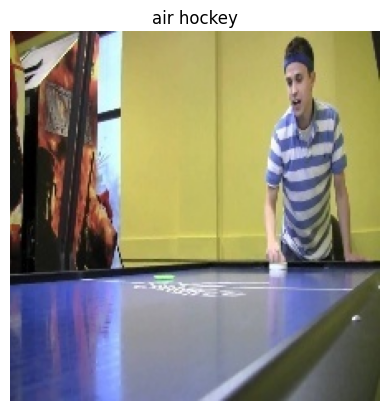

In [11]:
from PIL import Image

import matplotlib.pyplot as plt

# Load and display the first image
image_path = os.path.join("data", df_train.iloc[0]['filepaths'])
image = Image.open(image_path)

plt.imshow(image)
plt.axis('off')
plt.title(df_train.iloc[0]['labels'])
plt.show()

# 5.0 ML Model Training - Baseline (LR & SGD)

In [12]:
from sklearn.decomposition import PCA
import numpy as np

# Optional: ensure memory efficiency
# X_train = X_train.astype(np.float32)
# X_valid = X_valid.astype(np.float32)

# Ensure X_train and X_valid are NumPy arrays
X_train = np.array(X_train)
X_valid = np.array(X_valid)

# Flatten to (n_samples, height * width)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_valid_flat = X_valid.reshape(X_valid.shape[0], -1)


# PCA with whitening (does mean-centering + variance scaling)
pca = PCA(n_components=500, svd_solver='randomized', whiten=True)

X_train_pca = pca.fit_transform(X_train_flat)
X_valid_pca = pca.transform(X_valid_flat)

print("Original shape:", X_train.shape)
print("Reduced shape:", X_train_pca.shape)


Original shape: (13492, 224, 224)
Reduced shape: (13492, 500)


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

model = LogisticRegression(max_iter=1000, verbose=1)
model.fit(X_train_pca, y_train_enc)

y_pred = model.predict(X_valid_pca)
print("Accuracy:", accuracy_score(y_valid_enc, y_pred))
print(classification_report(y_valid_enc, y_pred, target_names=le.classes_))


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        50100     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.60517D+00    |proj g|=  1.77336D-02


 This problem is unconstrained.



At iterate   50    f=  1.67216D+00    |proj g|=  1.04602D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
50100     53     55      1     0     0   7.661D-05   1.672D+00
  F =   1.6719311523454827     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Accuracy: 0.062
                       precision    recall  f1-score   support

           air hockey       0.20      0.20      0.20         5
      ampute football       0.00      0.00      0.00         5
              archery       0.00      0.00      0.00         5
        arm wrestling       0.00      0.00      0.00         5
         axe throwing       0

In [21]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score

# Optional: for better performance
# X_train = X_train.astype(np.float32)
# X_valid = X_valid.astype(np.float32)

# Ensure X_train and X_valid are NumPy arrays
X_train = np.array(X_train)
X_valid = np.array(X_valid)

# Flatten to (n_samples, height * width)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_valid_flat = X_valid.reshape(X_valid.shape[0], -1)

model = SGDClassifier(loss='log_loss',  # logistic regression
                      max_iter=1000,
                      tol=1e-3,
                      n_jobs=-1,        # use all CPU cores
                      random_state=42)

model.fit(X_train_flat, y_train_enc)

y_pred = model.predict(X_valid_flat)
print("Accuracy:", accuracy_score(y_valid_enc, y_pred))
print(classification_report(y_valid_enc, y_pred, target_names=le.classes_))


Accuracy: 0.064
                       precision    recall  f1-score   support

           air hockey       1.00      0.20      0.33         5
      ampute football       0.00      0.00      0.00         5
              archery       0.00      0.00      0.00         5
        arm wrestling       0.25      0.20      0.22         5
         axe throwing       0.00      0.00      0.00         5
         balance beam       0.50      0.40      0.44         5
        barell racing       0.00      0.00      0.00         5
             baseball       0.00      0.00      0.00         5
           basketball       0.00      0.00      0.00         5
       baton twirling       0.00      0.00      0.00         5
            bike polo       0.00      0.00      0.00         5
            billiards       0.00      0.00      0.00         5
                  bmx       0.00      0.00      0.00         5
              bobsled       0.00      0.00      0.00         5
              bowling       0.00      

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 6.0 HOG + SGD Approach 

In [22]:
from sklearn.preprocessing import LabelEncoder
from hog_transformer import HOGTransformer
from data_utils import ImagePreprocessor

# Load dataset
df = pd.read_csv("data/sports.csv")
df_train = df[df["data set"] == "train"]
df_valid = df[df["data set"] == "valid"]

# Preprocess images (grayscale conversion + resize)
preprocessor = ImagePreprocessor(base_path="data")
X_train_gray, y_train_labels = preprocessor.load_and_preprocess(df_train)
X_valid_gray, y_valid_labels = preprocessor.load_and_preprocess(df_valid)


100%|██████████| 500/500 [00:06<00:00, 73.92it/s]


In [9]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_labels)
y_valid_enc = le.transform(y_valid_labels)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

pipeline = Pipeline([
    ("hog", HOGTransformer()),  # default HOG settings
    ("clf", SGDClassifier(loss='log_loss', max_iter=1000, n_jobs=-1, random_state=42))
])

pipeline.fit(X_train_gray, y_train_enc)


100%|██████████| 13492/13492 [04:16<00:00, 52.66it/s]


Pipeline(steps=[('hog', HOGTransformer()),
                ('clf',
                 SGDClassifier(loss='log_loss', n_jobs=-1, random_state=42))])

100%|██████████| 500/500 [00:10<00:00, 48.78it/s]
c:\Users\Caio Santos\.conda\envs\venv-fproject\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Caio Santos\.conda\envs\venv-fproject\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Caio Santos\.conda\envs\venv-fproject\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavio

Accuracy: 0.218
                       precision    recall  f1-score   support

           air hockey       0.00      0.00      0.00         5
      ampute football       0.00      0.00      0.00         5
              archery       0.25      0.20      0.22         5
        arm wrestling       1.00      0.80      0.89         5
         axe throwing       1.00      0.20      0.33         5
         balance beam       0.00      0.00      0.00         5
        barell racing       0.00      0.00      0.00         5
             baseball       0.00      0.00      0.00         5
           basketball       0.00      0.00      0.00         5
       baton twirling       0.00      0.00      0.00         5
            bike polo       0.60      0.60      0.60         5
            billiards       0.00      0.00      0.00         5
                  bmx       0.00      0.00      0.00         5
              bobsled       0.00      0.00      0.00         5
              bowling       0.00      

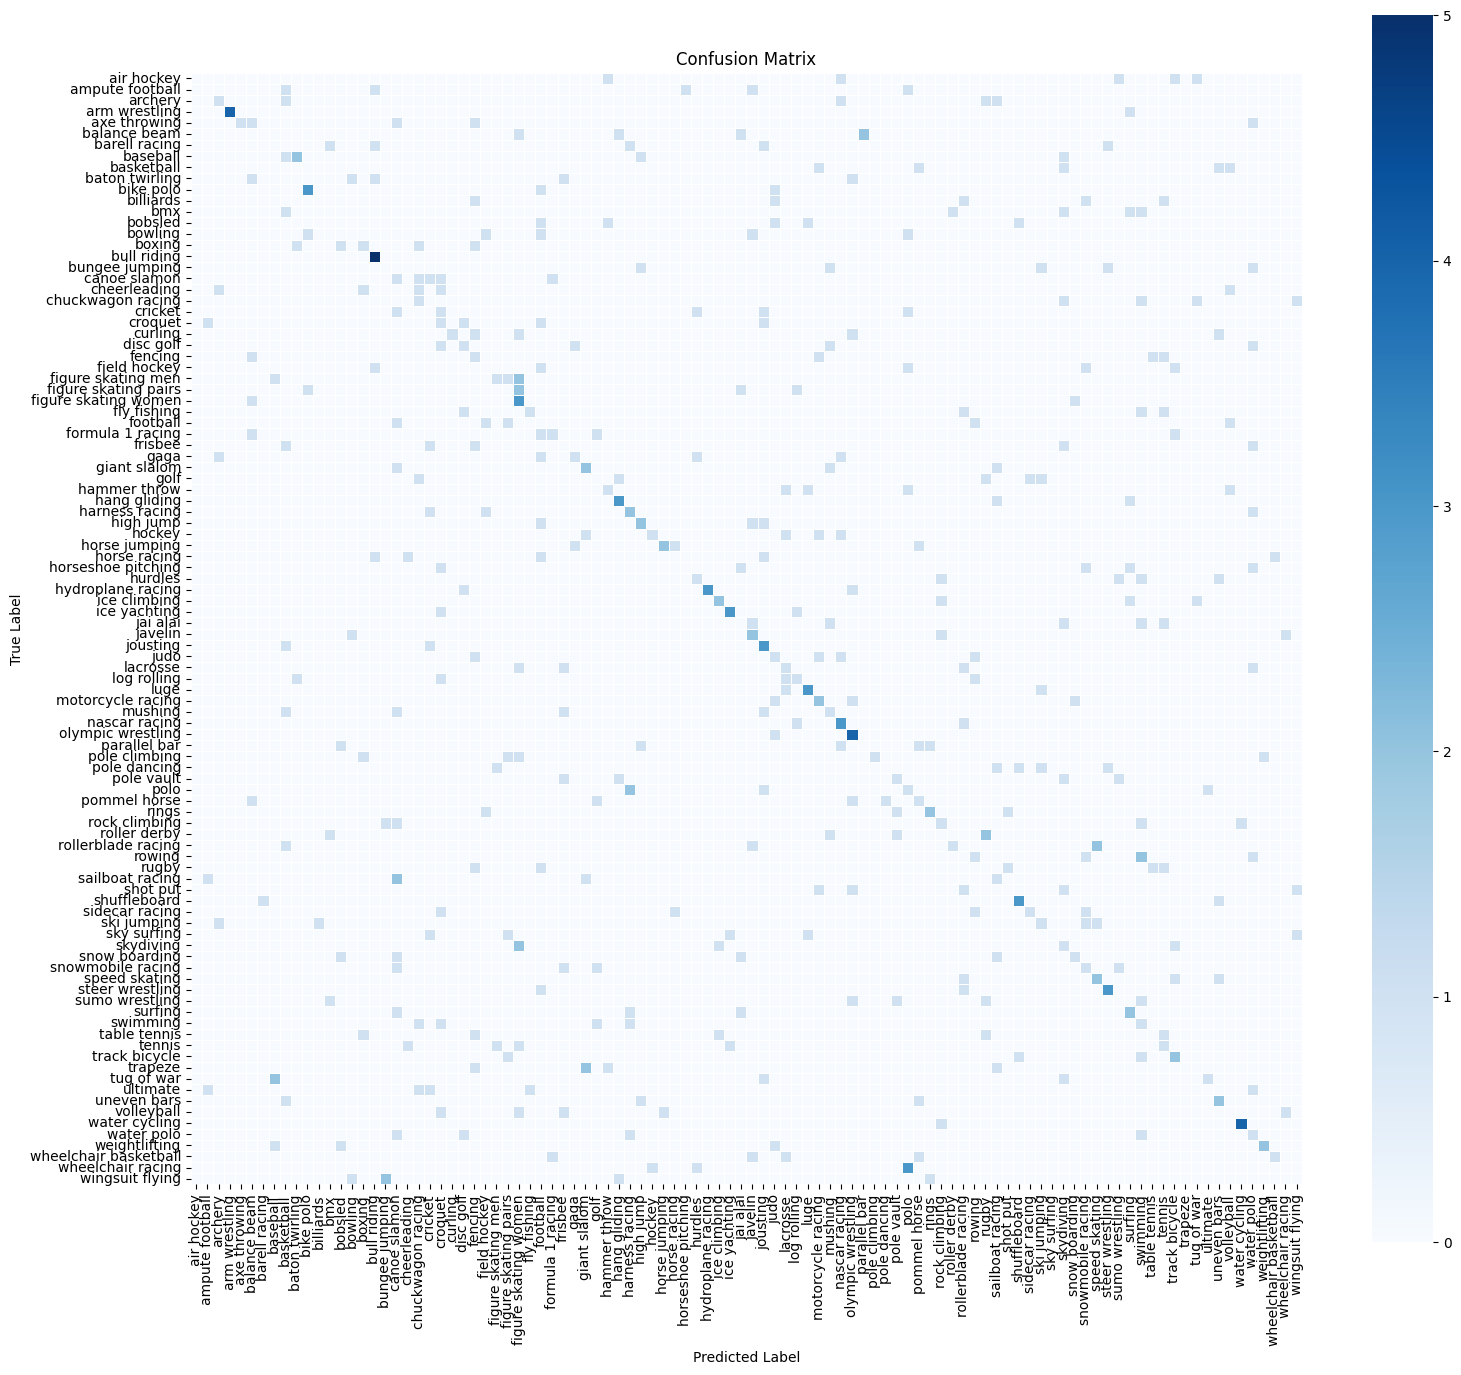

In [6]:
from sklearn.metrics import classification_report, accuracy_score
from data_utils import plot_confusion_matrix 

# Predict
y_pred = pipeline.predict(X_valid_gray)

# Evaluate
print("Accuracy:", accuracy_score(y_valid_enc, y_pred))
print(classification_report(y_valid_enc, y_pred, target_names=le.classes_))
plot_confusion_matrix(y_valid_enc, y_pred, class_labels=le.classes_)


## 6.1 HOG Gridsearch + SGD Gridsearch

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from hog_transformer import HOGTransformer
from data_utils import plot_confusion_matrix
from sklearn.metrics import classification_report, accuracy_score


In [11]:

# Define pipeline with fixed SGD
pipeline = Pipeline([
    ("hog", HOGTransformer()),
    ("clf", SGDClassifier(loss='log_loss', max_iter=1000, n_jobs=-1, random_state=42))
])

# Grid with wider parameter spacing
param_grid = {
    "hog__orientations": [6, 9, 12],
    "hog__pixels_per_cell": [(8, 8), (16, 16), (32, 32)],
    "hog__cells_per_block": [(2, 2), (4, 4)],
    "hog__block_norm": ['L2-Hys'],  # keep this fixed for now
}


In [13]:
# Grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring="accuracy",
    verbose=2,
    n_jobs=1
)

# Fit
grid_search.fit(X_train_gray, y_train_enc)

# Best HOG config
print("Best HOG Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


100%|██████████| 4498/4498 [01:21<00:00, 55.40it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=6, hog__pixels_per_cell=(8, 8); total time= 5.2min


100%|██████████| 4497/4497 [01:16<00:00, 58.92it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=6, hog__pixels_per_cell=(8, 8); total time= 5.0min


100%|██████████| 4497/4497 [01:15<00:00, 59.29it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=6, hog__pixels_per_cell=(8, 8); total time=34.8min


100%|██████████| 4498/4498 [00:28<00:00, 156.07it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=6, hog__pixels_per_cell=(16, 16); total time= 1.7min


100%|██████████| 4497/4497 [00:28<00:00, 156.10it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=6, hog__pixels_per_cell=(16, 16); total time= 1.7min


100%|██████████| 4497/4497 [00:28<00:00, 155.70it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=6, hog__pixels_per_cell=(16, 16); total time= 1.7min


100%|██████████| 4498/4498 [00:21<00:00, 211.41it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=6, hog__pixels_per_cell=(32, 32); total time= 1.1min


100%|██████████| 4497/4497 [00:21<00:00, 212.21it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=6, hog__pixels_per_cell=(32, 32); total time= 1.1min


100%|██████████| 4497/4497 [00:21<00:00, 211.50it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=6, hog__pixels_per_cell=(32, 32); total time= 1.1min


100%|██████████| 4498/4498 [01:18<00:00, 57.23it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(8, 8); total time= 5.6min


100%|██████████| 4497/4497 [01:18<00:00, 57.23it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(8, 8); total time= 5.6min


100%|██████████| 4497/4497 [01:18<00:00, 57.40it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(8, 8); total time= 5.5min


100%|██████████| 4498/4498 [00:34<00:00, 131.92it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(16, 16); total time= 2.1min


100%|██████████| 4497/4497 [00:33<00:00, 132.34it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(16, 16); total time= 2.1min


100%|██████████| 4497/4497 [00:34<00:00, 131.65it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(16, 16); total time= 2.1min


100%|██████████| 4498/4498 [00:23<00:00, 192.47it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(32, 32); total time= 1.2min


100%|██████████| 4497/4497 [00:23<00:00, 193.76it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(32, 32); total time= 1.2min


100%|██████████| 4497/4497 [00:23<00:00, 192.57it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(32, 32); total time= 1.2min


100%|██████████| 4498/4498 [01:17<00:00, 57.76it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=12, hog__pixels_per_cell=(8, 8); total time= 6.1min


100%|██████████| 4497/4497 [01:17<00:00, 57.73it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=12, hog__pixels_per_cell=(8, 8); total time= 6.0min


100%|██████████| 4497/4497 [01:17<00:00, 57.79it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=12, hog__pixels_per_cell=(8, 8); total time= 5.9min


100%|██████████| 4498/4498 [00:36<00:00, 123.33it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=12, hog__pixels_per_cell=(16, 16); total time= 2.3min


100%|██████████| 4497/4497 [00:36<00:00, 123.26it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=12, hog__pixels_per_cell=(16, 16); total time= 2.3min


100%|██████████| 4497/4497 [00:36<00:00, 123.18it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=12, hog__pixels_per_cell=(16, 16); total time= 2.3min


100%|██████████| 4498/4498 [00:24<00:00, 181.98it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=12, hog__pixels_per_cell=(32, 32); total time= 1.3min


100%|██████████| 4497/4497 [00:24<00:00, 182.85it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=12, hog__pixels_per_cell=(32, 32); total time= 1.3min


100%|██████████| 4497/4497 [00:24<00:00, 182.39it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(2, 2), hog__orientations=12, hog__pixels_per_cell=(32, 32); total time= 1.3min


100%|██████████| 4498/4498 [01:11<00:00, 63.28it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=6, hog__pixels_per_cell=(8, 8); total time= 9.5min


100%|██████████| 4497/4497 [01:10<00:00, 63.57it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=6, hog__pixels_per_cell=(8, 8); total time= 9.5min


100%|██████████| 4497/4497 [01:10<00:00, 63.40it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=6, hog__pixels_per_cell=(8, 8); total time= 9.6min


100%|██████████| 4498/4498 [00:29<00:00, 153.11it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=6, hog__pixels_per_cell=(16, 16); total time= 2.2min


100%|██████████| 4497/4497 [00:28<00:00, 159.82it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=6, hog__pixels_per_cell=(16, 16); total time= 2.2min


100%|██████████| 4497/4497 [00:28<00:00, 159.46it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=6, hog__pixels_per_cell=(16, 16); total time= 2.2min


100%|██████████| 4498/4498 [00:18<00:00, 240.75it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=6, hog__pixels_per_cell=(32, 32); total time= 1.0min


100%|██████████| 4497/4497 [00:18<00:00, 242.80it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=6, hog__pixels_per_cell=(32, 32); total time= 1.0min


100%|██████████| 4497/4497 [00:18<00:00, 242.71it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=6, hog__pixels_per_cell=(32, 32); total time= 1.0min


100%|██████████| 4498/4498 [01:15<00:00, 59.66it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=9, hog__pixels_per_cell=(8, 8); total time=18.3min


100%|██████████| 4497/4497 [01:14<00:00, 60.02it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=9, hog__pixels_per_cell=(8, 8); total time=18.6min


100%|██████████| 4497/4497 [01:15<00:00, 59.86it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=9, hog__pixels_per_cell=(8, 8); total time=18.8min


100%|██████████| 4498/4498 [00:35<00:00, 126.10it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=9, hog__pixels_per_cell=(16, 16); total time= 2.9min


100%|██████████| 4497/4497 [00:30<00:00, 148.02it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=9, hog__pixels_per_cell=(16, 16); total time= 2.7min


100%|██████████| 4497/4497 [00:31<00:00, 143.86it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=9, hog__pixels_per_cell=(16, 16); total time= 2.8min


100%|██████████| 4498/4498 [00:20<00:00, 220.34it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=9, hog__pixels_per_cell=(32, 32); total time= 1.1min


100%|██████████| 4497/4497 [00:20<00:00, 221.60it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=9, hog__pixels_per_cell=(32, 32); total time= 1.1min


100%|██████████| 4497/4497 [00:20<00:00, 220.80it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=9, hog__pixels_per_cell=(32, 32); total time= 1.1min


100%|██████████| 4498/4498 [01:20<00:00, 55.78it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=12, hog__pixels_per_cell=(8, 8); total time=28.5min


100%|██████████| 4497/4497 [01:17<00:00, 58.34it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=12, hog__pixels_per_cell=(8, 8); total time=29.4min


100%|██████████| 4497/4497 [01:18<00:00, 57.35it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=12, hog__pixels_per_cell=(8, 8); total time=29.5min


100%|██████████| 4498/4498 [00:38<00:00, 117.75it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=12, hog__pixels_per_cell=(16, 16); total time= 3.3min


100%|██████████| 4497/4497 [00:32<00:00, 136.43it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=12, hog__pixels_per_cell=(16, 16); total time= 2.8min


100%|██████████| 4497/4497 [00:32<00:00, 137.09it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=12, hog__pixels_per_cell=(16, 16); total time= 3.1min


100%|██████████| 4498/4498 [00:21<00:00, 205.48it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=12, hog__pixels_per_cell=(32, 32); total time= 1.2min


100%|██████████| 4497/4497 [00:21<00:00, 205.83it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=12, hog__pixels_per_cell=(32, 32); total time= 1.2min


100%|██████████| 4497/4497 [00:21<00:00, 205.85it/s]


[CV] END hog__block_norm=L2-Hys, hog__cells_per_block=(4, 4), hog__orientations=12, hog__pixels_per_cell=(32, 32); total time= 1.2min


100%|██████████| 13492/13492 [01:06<00:00, 203.56it/s]


Best HOG Parameters: {'hog__block_norm': 'L2-Hys', 'hog__cells_per_block': (4, 4), 'hog__orientations': 12, 'hog__pixels_per_cell': (32, 32)}
Best CV Accuracy: 0.24125457351654392


100%|██████████| 500/500 [00:03<00:00, 164.92it/s]
c:\Users\Caio Santos\.conda\envs\venv-fproject\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Caio Santos\.conda\envs\venv-fproject\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Caio Santos\.conda\envs\venv-fproject\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

Validation Accuracy: 0.314
                       precision    recall  f1-score   support

           air hockey       0.00      0.00      0.00         5
      ampute football       1.00      0.20      0.33         5
              archery       0.60      0.60      0.60         5
        arm wrestling       0.80      0.80      0.80         5
         axe throwing       0.00      0.00      0.00         5
         balance beam       0.07      0.20      0.11         5
        barell racing       1.00      0.60      0.75         5
             baseball       0.00      0.00      0.00         5
           basketball       0.08      0.60      0.15         5
       baton twirling       0.00      0.00      0.00         5
            bike polo       0.50      0.20      0.29         5
            billiards       0.75      0.60      0.67         5
                  bmx       0.00      0.00      0.00         5
              bobsled       0.00      0.00      0.00         5
              bowling      

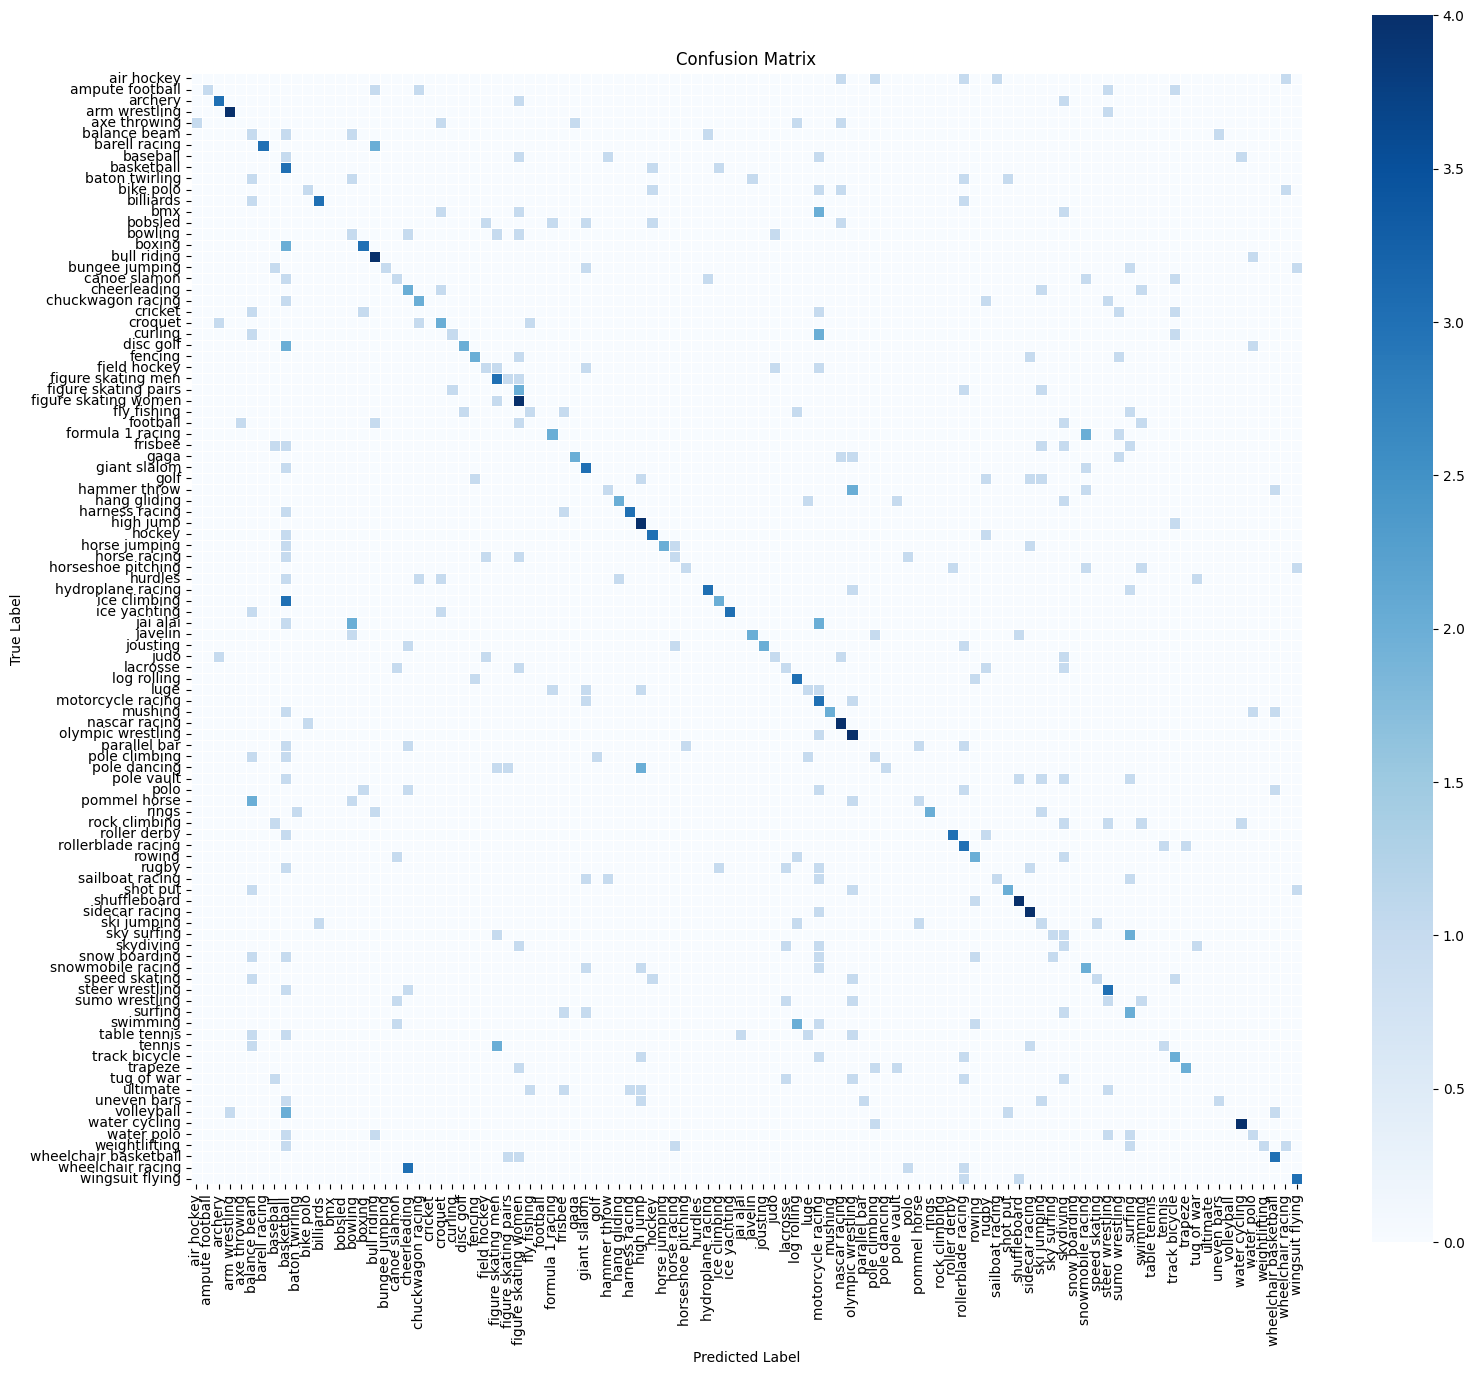

In [14]:

# Predict & Evaluate
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_valid_gray)

print("Validation Accuracy:", accuracy_score(y_valid_enc, y_pred))
print(classification_report(y_valid_enc, y_pred, target_names=le.classes_))
plot_confusion_matrix(y_valid_enc, y_pred, class_labels=le.classes_)


# 7.0 HOG + Random Forest Approach

In [7]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ("hog", HOGTransformer()),  
    ("clf", RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42))
])

pipeline.fit(X_train_gray, y_train_enc)


100%|██████████| 13492/13492 [04:04<00:00, 55.19it/s]


Pipeline(steps=[('hog', HOGTransformer()),
                ('clf', RandomForestClassifier(n_jobs=-1, random_state=42))])

In [ ]:
# Predict
y_pred = pipeline.predict(X_valid_gray)

# Evaluation
print("Accuracy:", accuracy_score(y_valid_enc, y_pred))
print(classification_report(y_valid_enc, y_pred, target_names=le.classes_))


100%|██████████| 500/500 [00:09<00:00, 52.39it/s]


Accuracy: 0.086
                       precision    recall  f1-score   support

           air hockey       0.00      0.00      0.00         5
      ampute football       0.00      0.00      0.00         5
              archery       0.25      0.20      0.22         5
        arm wrestling       0.40      0.40      0.40         5
         axe throwing       0.00      0.00      0.00         5
         balance beam       0.00      0.00      0.00         5
        barell racing       0.00      0.00      0.00         5
             baseball       0.00      0.00      0.00         5
           basketball       0.00      0.00      0.00         5
       baton twirling       0.00      0.00      0.00         5
            bike polo       0.00      0.00      0.00         5
            billiards       0.00      0.00      0.00         5
                  bmx       0.17      0.20      0.18         5
              bobsled       0.00      0.00      0.00         5
              bowling       0.00      

c:\Users\Caio Santos\.conda\envs\venv-fproject\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Caio Santos\.conda\envs\venv-fproject\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Caio Santos\.conda\envs\venv-fproject\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

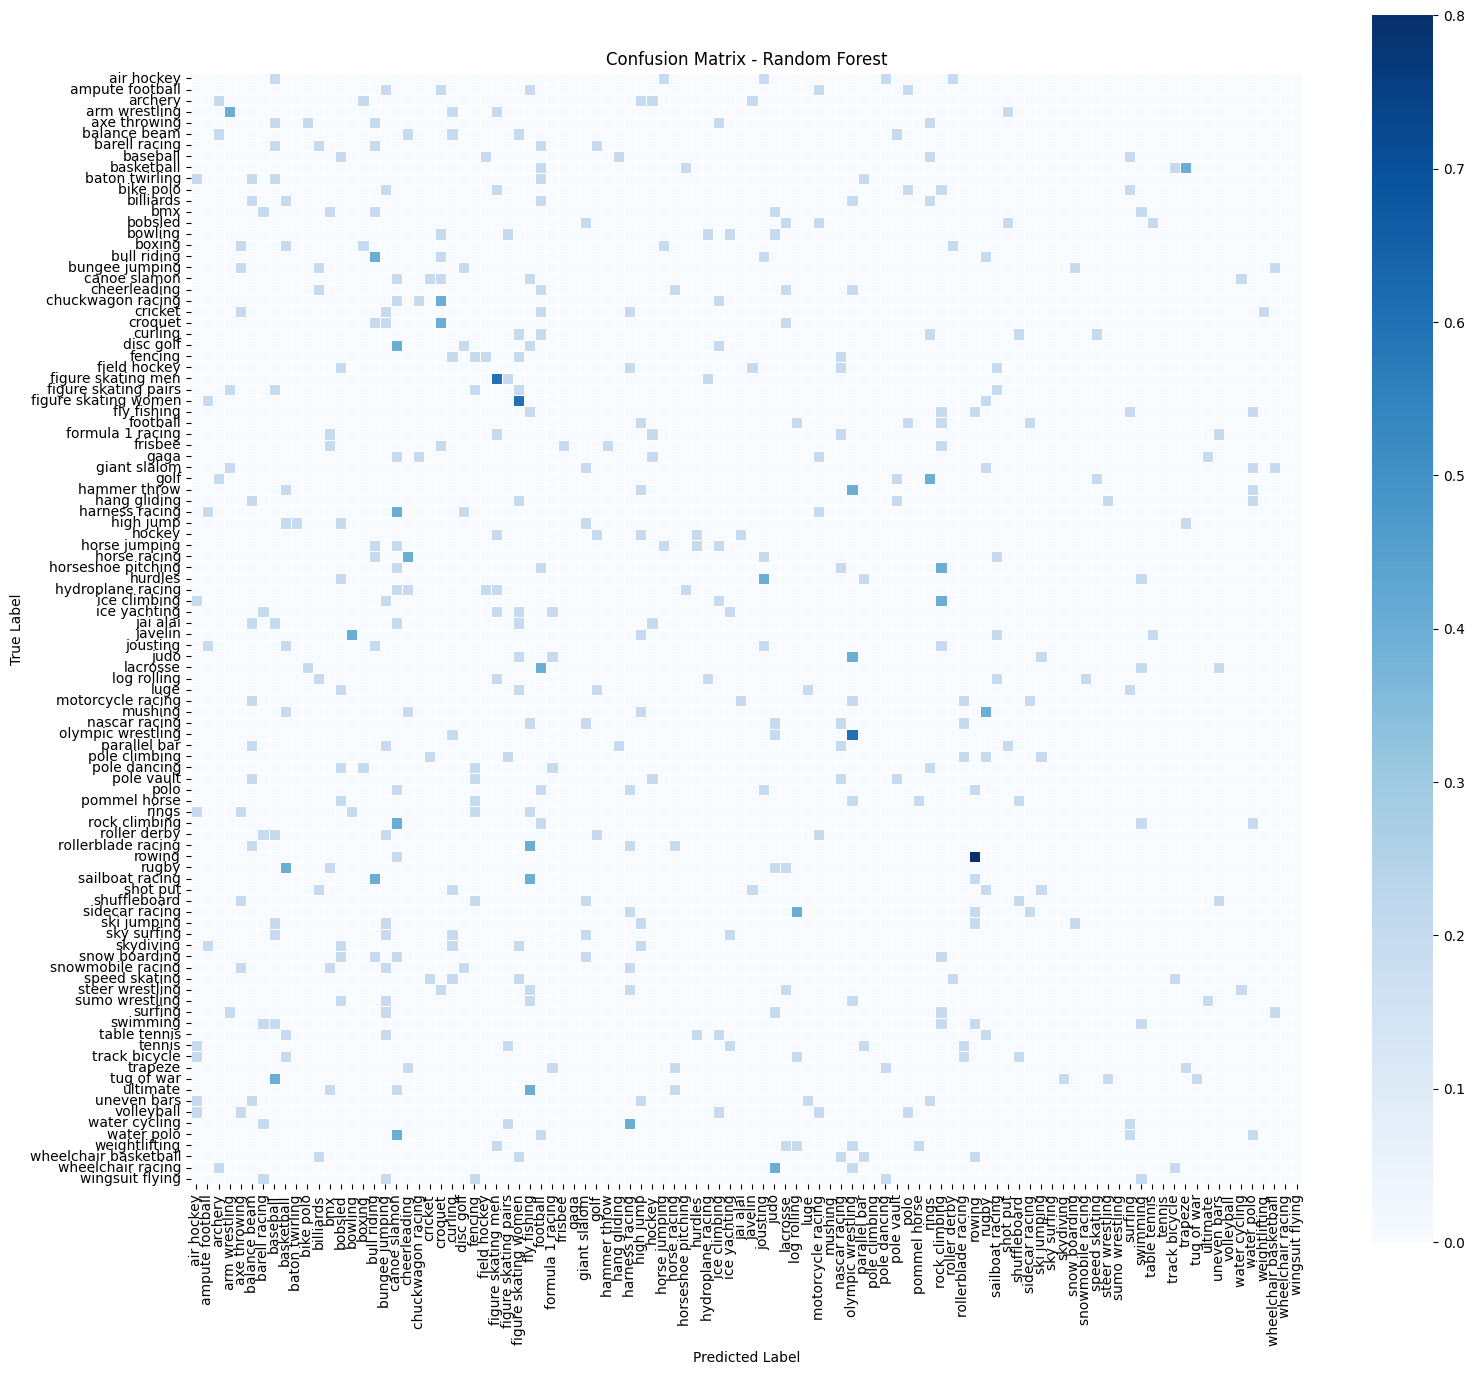

In [9]:

plot_confusion_matrix(
    y_valid_enc,
    y_pred,
    class_labels=le.classes_,
    normalize=True,
    title="Confusion Matrix - Random Forest"
)


# 8.0 ResNet50V2 pretrained model

In [24]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import pandas as pd
import os

# 1.0 Importing Libraries
import matplotlib.pyplot as plt

2025-04-11 21:47:31.998670: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# 2.0 Data Preparation
# Define paths
train_dir = os.path.join("data", "train")
valid_dir = os.path.join("data", "valid")

# Load dataset
df = pd.read_csv("data/sports.csv")
df_train = df[df["data set"] == "train"]
df_valid = df[df["data set"] == "valid"]



# Image data generators for augmentation
train_datagen = ImageDataGenerator(
  rescale=1.0/255.0,
  rotation_range=20,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load data
train_generator = train_datagen.flow_from_directory(
  train_dir,
  target_size=(224, 224),
  batch_size=32,
  class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
  valid_dir,
  target_size=(224, 224),
  batch_size=32,
  class_mode='categorical'
)


Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [ ]:
# 3.0 Model Creation
# Load ResNet50V2 as base model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# 4.0 Model Training
# Train the model
history = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=10,
  steps_per_epoch=train_generator.samples // train_generator.batch_size,
  validation_steps=valid_generator.samples // valid_generator.batch_size
)


In [ ]:
# 5.0 Fine-Tuning
# Unfreeze some layers of the base model
base_model.trainable = True
for layer in base_model.layers[:100]:
  layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=5,
  steps_per_epoch=train_generator.samples // train_generator.batch_size,
  validation_steps=valid_generator.samples // valid_generator.batch_size
)

In [ ]:
# 6.0 Accuracy and Loss Visualization
# Combine histories
history.history['accuracy'] += history_fine.history['accuracy']
history.history['val_accuracy'] += history_fine.history['val_accuracy']
history.history['loss'] += history_fine.history['loss']
history.history['val_loss'] += history_fine.history['val_loss']

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()